### Our Zillow scenario continues:

#### As a Codeup data science graduate, you want to show off your skills to the Zillow data science team in hopes of getting an interview for a position you saw pop up on LinkedIn. You thought it might look impressive to build an end-to-end project in which you use some of their Kaggle data to predict property values using some of their available features; who knows, you might even do some feature engineering to blow them away. Your goal is to predict the values of single unit properties using the observations from 2017.

#### In these exercises, you will run through the stages of exploration as you continue to work toward the above goal.

## 1. As with encoded vs. unencoded data, we recommend exploring un-scaled data in your EDA process.

Note: This notebook will be dedicated exploring data for the final zillow regression project.
Meaningful columns for data acquisition:

### Acquire

In [ ]:
'bathroomcnt'
'bedroomcnt'
'calculatedfinishedsquarefeet'
'fips'
'lotsizesquarefeet' # maybe?
'rawcensustractandblock' # maybe?
'regionidcounty'
'yearbuilt'
'taxvaluedollarcnt'
'taxamount'

In [2]:
# Importing libraries

import pandas as pd
import numpy as np
import requests
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, spearmanr
import statistics as s
import env

In [3]:
# Getting conncection to mySQL database, and acquiring data

def get_connection(db, user=env.user, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

# Loading raw data from Zillow database
def new_zillow_data():
    '''
    This function reads the Zillow data from the mySQL database into a df.
    '''
    # Create SQL query.
    sql_query = '''
    SELECT latitude, longitude, bedroomcnt as bedrooms, bathroomcnt as bathrooms, calculatedfinishedsquarefeet as square_feet, lotsizesquarefeet as lot_size, fips as fips_code, yearbuilt as year_built, taxvaluedollarcnt as assessed_value, taxamount as tax_amount
FROM properties_2017 as p JOIN predictions_2017 as pred USING(parcelid) JOIN
propertylandusetype as ptype using (propertylandusetypeid)
WHERE ptype.propertylandusedesc LIKE '%%Single%%' and pred.transactiondate LIKE '2017%%';
    '''
    # Read in DataFrame from Codeup db.
    df = pd.read_sql(sql_query, get_connection('zillow'))
    
    return df

In [4]:
# load raw, messy data

rawdf = new_zillow_data()

In [5]:
rawdf.shape

(52441, 10)

### Prepare

#### Drop null values

In [6]:
rawdf.isnull().sum()

latitude            0
longitude           0
bedrooms            0
bathrooms           0
square_feet        82
lot_size          369
fips_code           0
year_built        116
assessed_value      1
tax_amount          4
dtype: int64

In [7]:
# Dropping null values

df = rawdf.dropna()

In [8]:
df.shape

(51956, 10)

#### Data types

In [ ]:
df.dtypes

In [9]:
df['fips_code'] = df['fips_code'].astype(int)
df['year_built'] = df['year_built'].astype(int)

In [10]:
df.dtypes

latitude          float64
longitude         float64
bedrooms          float64
bathrooms         float64
square_feet       float64
lot_size          float64
fips_code           int64
year_built          int64
assessed_value    float64
tax_amount        float64
dtype: object

#### Data mapping?

##### Fips code:
- 6037 Los Angeles
- 6059 Orange
- 6111 Ventura


In [11]:
df['county'] = df.fips_code.map({6037: 'Los Angeles', 6059: 'Orange', 6111: 'Ventura'})

In [12]:
df.head()

,latitude,longitude,bedrooms,bathrooms,square_feet,lot_size,fips_code,year_built,assessed_value,tax_amount,county
0,34184517.0,-118221043.0,3.0,3.0,2538.0,39238.0,6037,1966,878288.0,9635.37,Los Angeles
1,33644714.0,-117616376.0,4.0,2.5,2761.0,5800.0,6059,1998,556255.0,8381.04,Orange
2,34262618.0,-118737528.0,3.0,2.5,1371.0,4321.0,6111,2012,404542.0,4705.74,Ventura
3,34181076.0,-118336609.0,3.0,2.0,1676.0,7025.0,6037,1940,283892.0,3151.85,Los Angeles
4,33814856.0,-118294446.0,4.0,3.0,2352.0,5398.0,6037,1989,293034.0,3839.25,Los Angeles


In [14]:
df = df.drop(['fips_code'], axis=1)

In [16]:
df.dtypes

latitude          float64
longitude         float64
bedrooms          float64
bathrooms         float64
square_feet       float64
lot_size          float64
year_built          int64
assessed_value    float64
tax_amount        float64
county             object
dtype: object

#### Outliers

In [13]:
# Display format
pd.options.display.float_format = '{:,.2f}'.format

<Figure size 432x432 with 0 Axes>

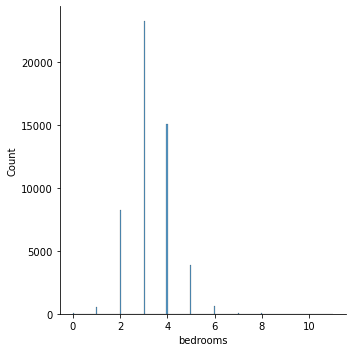

In [17]:
plt.figure(figsize = (6, 6))

sns.displot(x='bedrooms', data=df)

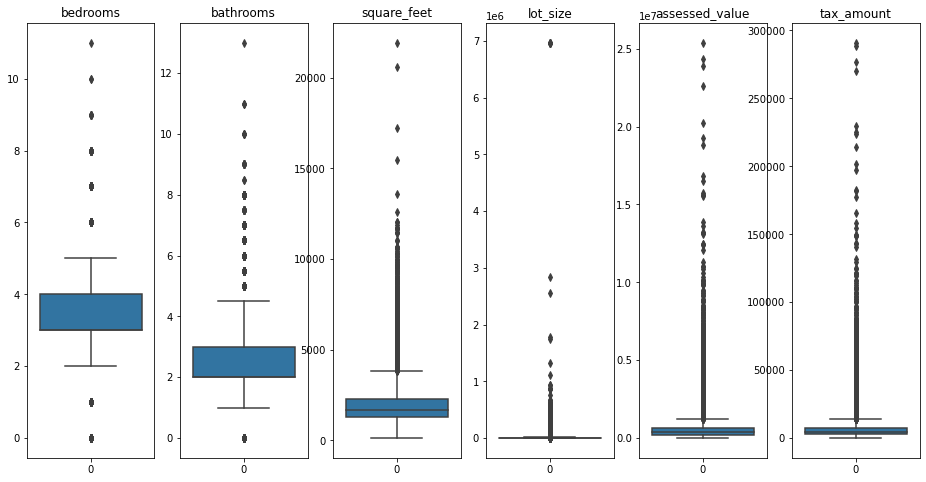

In [18]:
plt.figure(figsize = (16,8))

# List of columns
cols = ['bedrooms', 'bathrooms', 'square_feet','lot_size','assessed_value', 'tax_amount']

for i, col in enumerate(cols):
    
    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 
    
    # Create subplot.
    plt.subplot(1,6, plot_number)
    
    # Title with column name.
    plt.title(col)
    
    # Display histogram for column.
    sns.boxplot(data = df[col])


#### General rules:

lower bound: Q1 – (1.5 * IQR)
upper bound: Q3 + (1.5 * IQR)

##### bedrooms

In [19]:
df.bedrooms.describe()

count   51,956.00
mean         3.30
std          0.93
min          0.00
25%          3.00
50%          3.00
75%          4.00
max         11.00
Name: bedrooms, dtype: float64

In [20]:
q1 = np.percentile(df.bedrooms, 25)
q3 = np.percentile(df.bedrooms, 75)
iqr = q3 - q1
print("IQR equals: " + str(iqr))

IQR equals: 1.0


In [21]:
print("Upper bond for bedrooms: ", q3 + 2.5*iqr)
print("Lower bond for bedrooms: ", q1 - 2*iqr)

Upper bond for bedrooms:  6.5
Lower bond for bedrooms:  1.0


In [22]:
df[df.bedrooms>6.5].shape

(138, 10)

##### bathrooms

In [23]:
df.bathrooms.describe()

count   51,956.00
mean         2.30
std          1.01
min          0.00
25%          2.00
50%          2.00
75%          3.00
max         13.00
Name: bathrooms, dtype: float64

In [24]:
q1 = np.percentile(df.bathrooms, 25)
q3 = np.percentile(df.bathrooms, 75)
iqr = q3 - q1
print("IQR equals: " + str(iqr))

IQR equals: 1.0


In [25]:
print("Upper bond for bedrooms: ", q3 + 3.5*iqr)
print("Lower bond for bedrooms: ", q1 - 1.5*iqr)

Upper bond for bedrooms:  6.5
Lower bond for bedrooms:  0.5


In [26]:
df[df.bathrooms>6.5].shape

(178, 10)

##### square_feet

In [27]:
df.square_feet.describe()

count   51,956.00
mean     1,918.27
std        994.32
min        128.00
25%      1,268.00
50%      1,657.00
75%      2,301.00
max     21,929.00
Name: square_feet, dtype: float64

In [28]:
q1 = np.percentile(df.square_feet, 25)
q3 = np.percentile(df.square_feet, 75)
iqr = q3 - q1
print("IQR equals: " + str(iqr))

IQR equals: 1033.0


In [29]:
print("Upper bond for square_feet: ", q3 + 5.5*iqr)
print("Lower bond for square_feet: ", q1 - 0.75*iqr)

Upper bond for square_feet:  7982.5
Lower bond for square_feet:  493.25


In [30]:
df[df.square_feet>7982].shape

(102, 10)

In [31]:
df[df.square_feet<493].shape

(73, 10)

##### lot_size

In [32]:
df.lot_size.describe()

count      51,956.00
mean       11,251.78
std        86,643.13
min           236.00
25%         5,581.00
50%         6,838.00
75%         8,777.00
max     6,971,010.00
Name: lot_size, dtype: float64

In [33]:
q1 = np.percentile(df.lot_size, 25)
q3 = np.percentile(df.lot_size, 75)
iqr = q3 - q1
print("IQR equals: " + str(iqr))

IQR equals: 3196.0


In [34]:
print("Upper bond for square_feet: ", q3 + 45*iqr)
print("Lower bond for square_feet: ", q1 - 1.5*iqr)

Upper bond for square_feet:  152597.0
Lower bond for square_feet:  787.0


In [35]:
df[df.lot_size>152597].shape

(171, 10)

In [36]:
df[df.lot_size<787].shape

(55, 10)

##### assessed_value

In [37]:
df.assessed_value.describe()

count       51,956.00
mean       525,518.65
std        716,429.97
min          1,000.00
25%        193,478.50
50%        372,791.00
75%        616,656.25
max     25,381,250.00
Name: assessed_value, dtype: float64

In [38]:
q1 = np.percentile(df.assessed_value, 25)
q3 = np.percentile(df.assessed_value, 75)
iqr = q3 - q1
print("IQR equals: " + str(iqr))

IQR equals: 423177.75


In [39]:
print("Upper bond for assessed_value: ", q3 + 4.5*iqr)
print("Lower bond for assessed_value: ", q1 - 0.35 *iqr)

Upper bond for assessed_value:  2520956.125
Lower bond for assessed_value:  45366.287500000006


In [40]:
df[df.assessed_value<45366].shape[0]/df.shape[0]

0.019478019862960966

In [41]:
df[df.assessed_value>2520956].shape[0]/df.shape[0]

0.016206020478866733

##### outliers summary

In [42]:
df = df[df.bedrooms <= 6.5]
df = df[df.bedrooms >= 1]

df = df[df.bathrooms <= 6.5]
df = df[df.bathrooms >= 0.5]

df = df[df.square_feet <= 7982]
df = df[df.square_feet >= 493]

df = df[df.lot_size <= 152597]
df = df[df.lot_size >= 787]

df = df[df.assessed_value <= 2520956]
df = df[df.assessed_value >= 45366]

In [43]:
df.shape

(49633, 10)

#### Split data

In [44]:
def split(df):
    '''
    This function drops the customer_id column and then splits a dataframe into 
    train, validate, and test in order to explore the data and to create and validate models. 
    It takes in a dataframe and contains an integer for setting a seed for replication. 
    Test is 20% of the original dataset. The remaining 80% of the dataset is 
    divided between valiidate and train, with validate being .30*.80= 24% of 
    the original dataset, and train being .70*.80= 56% of the original dataset. 
    The function returns, train, validate and test dataframes. 
    '''
    train, test = train_test_split(df, test_size = .2, random_state=123)   
    train, validate = train_test_split(train, test_size=.3, random_state=123)
    
    return train, validate, test

In [45]:
train, validate, test = split(df)

In [46]:
train.shape, validate.shape, test.shape

((27794, 10), (11912, 10), (9927, 10))

In [ ]:
# Prepare.py functions:

def prep_zillow(df):
    # Drop outliers
    df = df.dropna()
    
    # Change data type
    df['fips_code'] = df['fips_code'].astype(int)
    df['year_built'] = df['year_built'].astype(int)
    
    # Data mapping
    df['county'] = df.fips_code.map({6037: 'Los Angeles', 6059: 'Orange', 6111: 'Ventura'})
    
    # Drop column
    df = df.drop(['fips_code'], axis=1)
    
    # Handle Outliers:
    # The general rule for outliers are:
    ## Upper bond: Q3 + 1.5*IQR
    ## Lower bund: Q1 - 1.5*IQR
    # Bonds are manually adjusted for each feature
    df = df[df.bedrooms <= 6.5]
    df = df[df.bedrooms >= 1]

    df = df[df.bathrooms <= 6.5]
    df = df[df.bathrooms >= 0.5]

    df = df[df.square_feet <= 7982]
    df = df[df.square_feet >= 493]

    df = df[df.lot_size <= 152597]
    df = df[df.lot_size >= 787]

    df = df[df.assessed_value <= 2520956]
    df = df[df.assessed_value >= 45366]

def split(df):
    '''
    This function drops the customer_id column and then splits a dataframe into 
    train, validate, and test in order to explore the data and to create and validate models. 
    It takes in a dataframe and contains an integer for setting a seed for replication. 
    Test is 20% of the original dataset. The remaining 80% of the dataset is 
    divided between valiidate and train, with validate being .30*.80= 24% of 
    the original dataset, and train being .70*.80= 56% of the original dataset. 
    The function returns, train, validate and test dataframes. 
    '''
    train, test = train_test_split(df, test_size = .2, random_state=123)   
    train, validate = train_test_split(train, test_size=.3, random_state=123)
    
    return train, validate, test

## 2. Make sure to perform a train, validate, test split before and use only your train dataset to explore the relationships between independent variables with other independent variables or independent variables with your target variable.

In [47]:
train.head()

,latitude,longitude,bedrooms,bathrooms,square_feet,lot_size,year_built,assessed_value,tax_amount,county
37569,"33,863,169.00","-118,076,077.00",2.00,1.00,752.00,"4,578.00",1945,"344,000.00","4,288.63",Los Angeles
34742,"34,229,579.00","-118,605,717.00",4.00,2.00,"1,795.00","13,305.00",1963,"79,896.00","1,190.07",Los Angeles
17160,"34,137,359.00","-118,406,170.00",3.00,2.00,"1,458.00","13,304.00",1950,"527,847.00","6,478.29",Los Angeles
37728,"34,311,526.00","-118,421,146.00",3.00,2.00,"1,173.00","7,337.00",1957,"342,234.00","4,137.93",Los Angeles
22416,"33,554,928.00","-117,631,141.00",3.00,2.50,"1,828.00","2,414.00",2002,"600,609.00","8,503.78",Orange


## 3. Write a function named `plot_variable_pairs` that accepts a dataframe as input and plots all of the pairwise relationships along with the regression line for each pair.

In [48]:
def plot_variable_pairs(df):
    return sns.pairplot(df, corner = True, kind='reg', plot_kws={'line_kws':{'color':'red'}, 'scatter_kws':{'s': 1, 'alpha': 0.5}})

<Figure size 1440x1440 with 0 Axes>

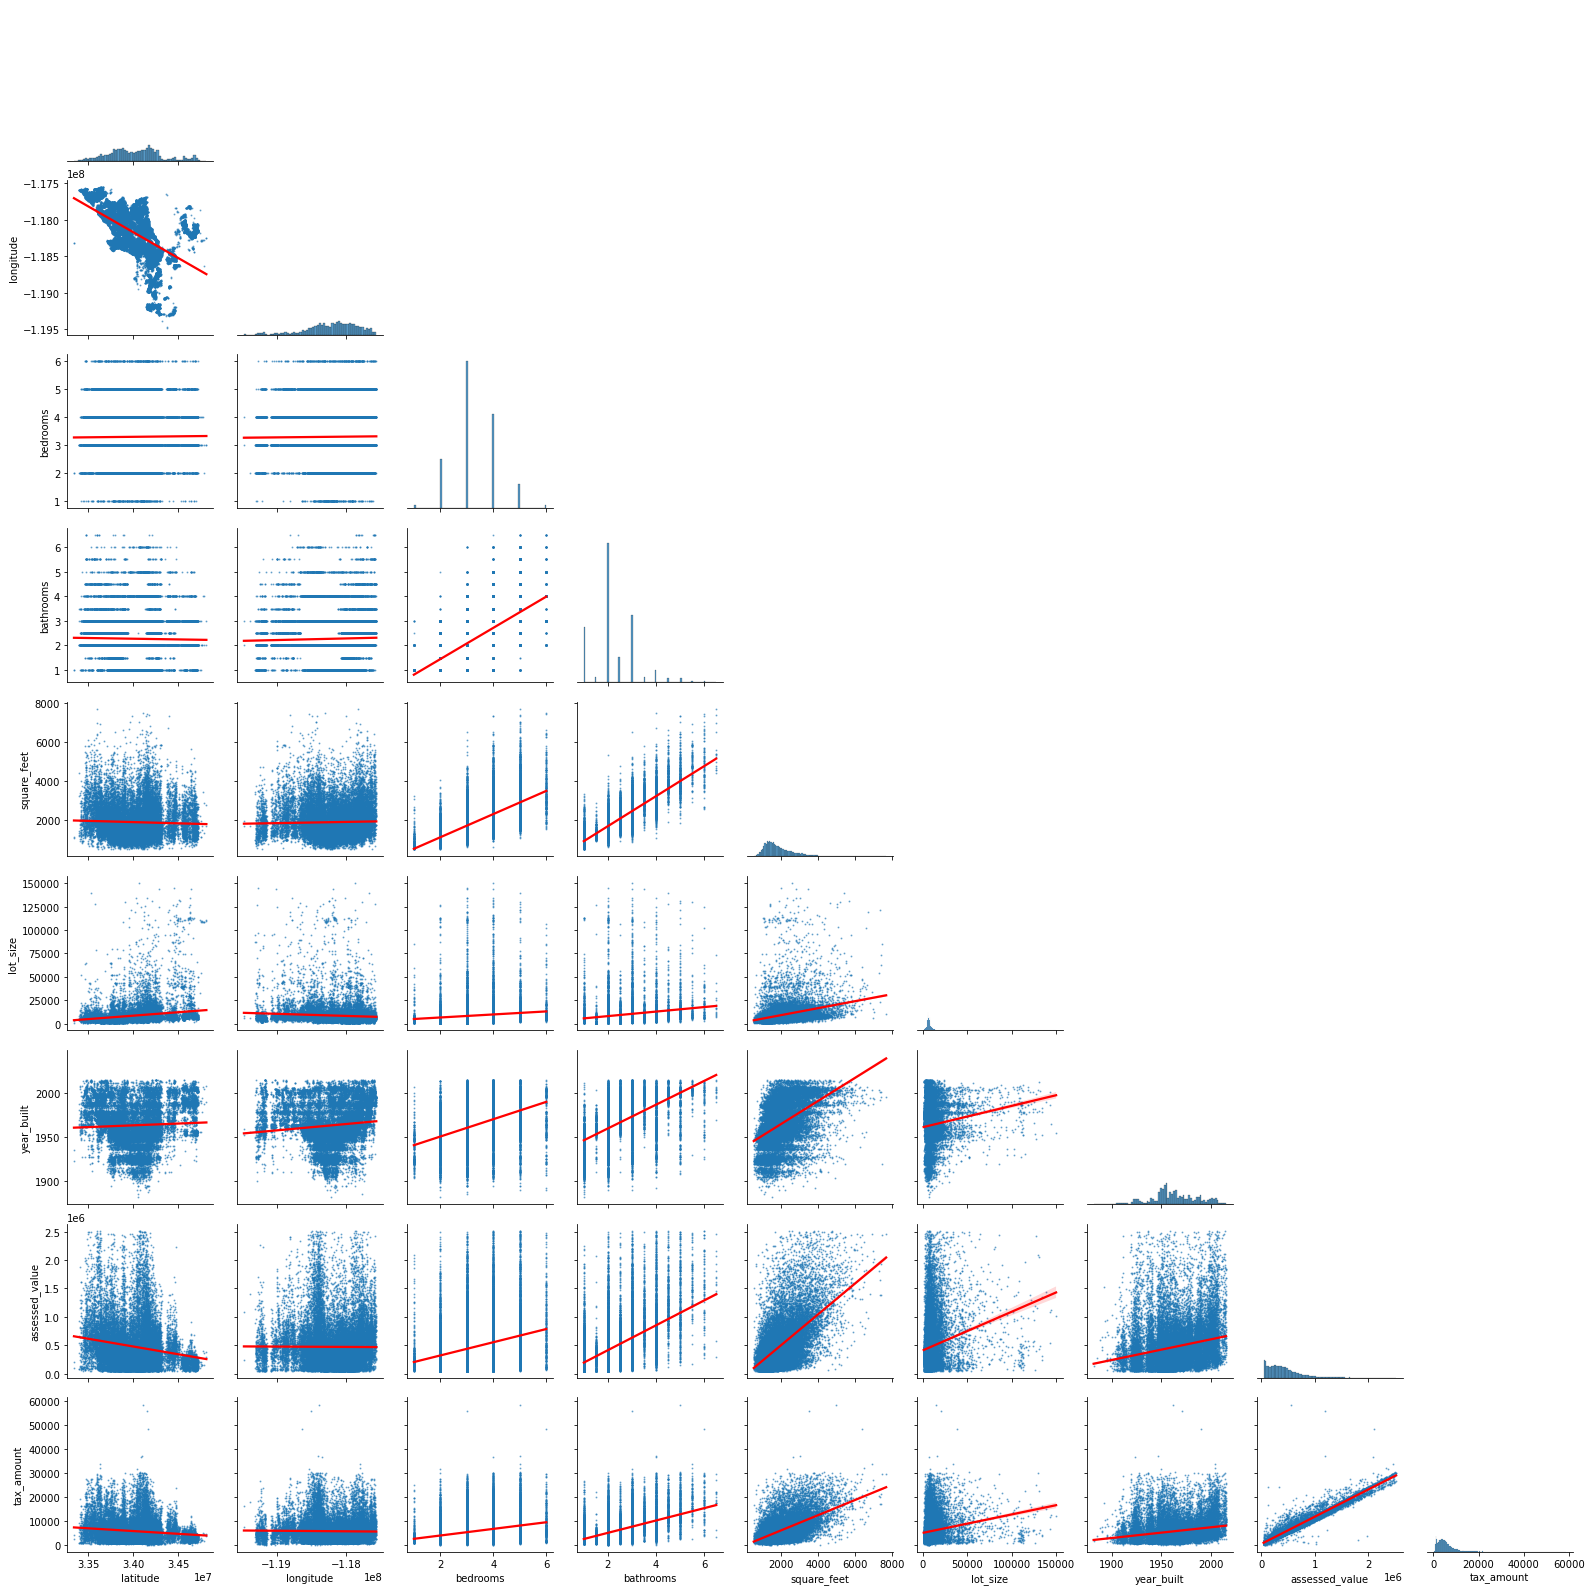

In [49]:
# ploting pairplot
plt.figure(figsize= (20,20))

plot_variable_pairs(train)

## 4. Write a function named `plot_categorical`_and_`continuous_vars` that accepts your dataframe and the name of the columns that hold the continuous and categorical features and outputs 3 different plots for visualizing a categorical variable and a continuous variable.

In [ ]:
categorical_cols = ['county_id', 'year_built']
continuous_cols = ['latitude','longitude', 'bedrooms', 'bathrooms', 'square_feet', 
                  'lot_size', 'assessed_value', 'tax_amount']

In [ ]:
plt.figure(figsize=(16, 3))

for i, col in enumerate(categorical_cols):
    
    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1
    
    # Create subplot.
    # plt.subplot(row X col, where?)
    plt.subplot(1,3,plot_number)
    
    # Title with column name.
    plt.title(col)
    
    # Display histogram for column.
    train[col].hist(bins=5, edgecolor='black')
    
    # Hide gridlines.
    plt.grid(False)

## 5. Save the functions you have written to create visualizations in your explore.py file. Rewrite your notebook code so that you are using the functions imported from this file.

## 6. Use the functions you created above to explore your Zillow train dataset in your explore.ipynb notebook.

## 7. Come up with some initial hypotheses based on your goal of predicting property value.

## 8. Visualize all combinations of variables in some way.

In [51]:
train_corr = train.corr()
train_corr

,latitude,longitude,bedrooms,bathrooms,square_feet,lot_size,year_built,assessed_value,tax_amount
latitude,1.00,-0.55,0.01,-0.02,-0.04,0.20,0.05,-0.19,-0.14
longitude,-0.55,1.00,0.01,0.03,0.03,-0.08,0.11,-0.01,-0.02
bedrooms,0.01,0.01,1.00,0.62,0.63,0.15,0.39,0.26,0.27
bathrooms,-0.02,0.03,0.62,1.00,0.83,0.22,0.54,0.51,0.51
square_feet,-0.04,0.03,0.63,0.83,1.00,0.31,0.48,0.58,0.58
lot_size,0.20,-0.08,0.15,0.22,0.31,1.00,0.11,0.17,0.17
year_built,0.05,0.11,0.39,0.54,0.48,0.11,1.00,0.21,0.22
assessed_value,-0.19,-0.01,0.26,0.51,0.58,0.17,0.21,1.00,0.97
tax_amount,-0.14,-0.02,0.27,0.51,0.58,0.17,0.22,0.97,1.00


<AxesSubplot:>

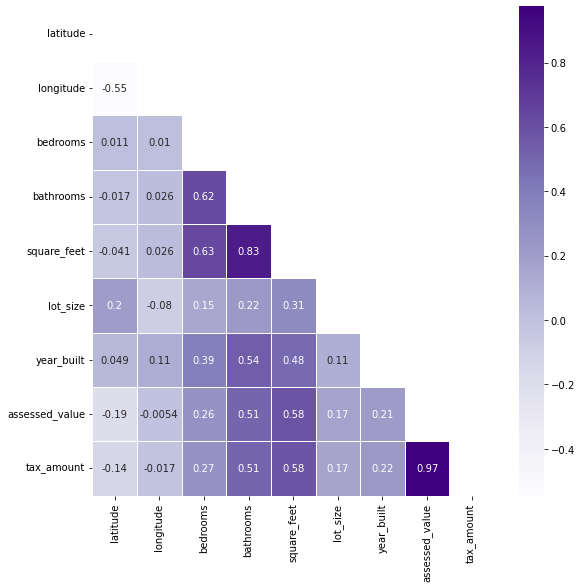

In [54]:
plt.figure(figsize = (9,9))
sns.heatmap(train_corr,cmap='Purples', annot=True, linewidth=0.5, mask= np.triu(train_corr))

## 9. Run the appropriate statistical tests where needed.

## 10. What independent variables are correlated with the dependent variable, home value?

## 11. Which independent variables are correlated with other independent variables (bedrooms, bathrooms, year built, square feet)?

## 12. Make sure to document your takeaways from visualizations and statistical tests as well as the decisions you make throughout your process.

## 13. Explore your dataset with any other visualizations you think will be helpful.